In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Libraries imported.


In [2]:
CLIENT_ID = 'AST22UD3GUYGDFMNBGDNG2GW43KRDAUNQLPHM5FHPAALA4Y1' # your Foursquare ID
CLIENT_SECRET = 'FNR0QGMJAYAZM5O1X3KCLTZ3ZVWE0R0LXI0TGTPEIETS4PXW' # your Foursquare Secret

VERSION = '20200401' # Foursquare API version
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AST22UD3GUYGDFMNBGDNG2GW43KRDAUNQLPHM5FHPAALA4Y1
CLIENT_SECRET:FNR0QGMJAYAZM5O1X3KCLTZ3ZVWE0R0LXI0TGTPEIETS4PXW


In [4]:
# Read in the data 
df = pd.read_csv("/Users/jhanviram/Downloads/london_crime_by_lsoa.csv")

In [5]:
#View the top rows of the dataset
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [6]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [7]:
# Shape of the data frame
df.shape

(392042, 7)

In [8]:
# View the top of the dataset 
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [9]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [10]:
# View the information of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   LSOA_Code       392042 non-null  object
 1   Borough         392042 non-null  object
 2   Major_Category  392042 non-null  object
 3   Minor_Category  392042 non-null  object
 4   No_of_Crimes    392042 non-null  int64 
 5   Year            392042 non-null  int64 
 6   Month           392042 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


In [11]:
df['Borough'].value_counts()

Lambeth                   17605
Southwark                 16560
Croydon                   16254
Newham                    15622
Ealing                    15284
Tower Hamlets             15219
Brent                     14980
Barnet                    14668
Hackney                   14392
Lewisham                  14235
Haringey                  14202
Enfield                   13658
Wandsworth                13498
Westminster               13383
Islington                 13116
Greenwich                 12750
Camden                    12632
Hillingdon                12417
Hounslow                  12316
Waltham Forest            12121
Bromley                   11980
Redbridge                 11490
Hammersmith and Fulham    10281
Barking and Dagenham       9784
Havering                   9699
Kensington and Chelsea     9653
Harrow                     8257
Bexley                     8245
Merton                     8223
Richmond upon Thames       7199
Sutton                     6823
Kingston

In [12]:
df['Major_Category'].value_counts()

Theft and Handling             129159
Violence Against the Person    123050
Criminal Damage                 48584
Burglary                        43020
Drugs                           21782
Robbery                         14889
Other Notifiable Offences       11558
Name: Major_Category, dtype: int64

In [13]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham         1287            1949   919   
Barnet                       3402            2183   906   
Bexley                       1123            1673   646   
Brent                        2631            2280  2096   
Bromley                      2214            2202   728   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       378     534               5607   
Barnet                                     499     464               9731   
Bexley                                     294     209               4392   
Brent                                      536     919               9026   
Bromley                                    417     369               7584   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        6067  
Barnet                                      7499  
Bexley                                      4503  
Brent                                       9205  
Bromley                                     6650

In [14]:
# Reset the index
London_crime.reset_index(inplace = True)

In [15]:
# Total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(33)

Borough No_of_Crimes                        \
Major_Category                             Burglary Criminal Damage Drugs   
0                 Barking and Dagenham         1287            1949   919   
1                               Barnet         3402            2183   906   
2                               Bexley         1123            1673   646   
3                                Brent         2631            2280  2096   
4                              Bromley         2214            2202   728   
5                               Camden         2652            1935  1493   
6                       City of London            2               2    10   
7                              Croydon         2738            3219  1367   
8                               Ealing         2492            2562  1355   
9                              Enfield         2541            2136  1063   
10                           Greenwich         1780            2476   867   
11                             Hackney         2719            1981  1353   
12              Hammersmith and Fulham         1531            1408  1321   
13                            Haringey         2474            2233  1540   
14                              Harrow         1994            1212   473   
15                            Havering         1826            1804   718   
16                          Hillingdon         2229            2470  1042   
17                            Hounslow         1808            2213  1086   
18                           Islington         2051            1903  1777   
19              Kensington and Chelsea         1449            1051  1680   
20                Kingston upon Thames          879            1054   743   
21                             Lambeth         3087            2764  2738   
22                            Lewisham         2071            2351  1617   
23                              Merton         1419            1418   466   
24                              Newham         2115            2496  1684   
25                           Redbridge         1997            1650  1017   
26                Richmond upon Thames         1359            1148   320   
27                           Southwark         2946            2621  1838   
28                              Sutton         1233            1316   461   
29                       Tower Hamlets         2794            2357  1629   
30                      Waltham Forest         1873            1989  1042   
31                          Wandsworth         2351            1836   870   
32                         Westminster         3218            2179  2049   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    378     534               5607   
1                                    499     464               9731   
2                                    294     209               4392   
3                                    536     919               9026   
4                                    417     369               7584   
5                                    490     899              14088   
6                                      6       4                129   
7                                    718    1139               9229   
8                                    613     669              10040   
9                                    492     807               8037   
10                                   521     486               8010   
11                                   499    1030              11851   
12                                   474     397               8925   
13                                   551    1248              10554   
14                                   267     377               4537   
15                                   389     311               5919   
16                                  1305     420         

In [16]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [17]:
London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [18]:
# Shape of the data set 
London_crime.shape

(33, 9)

# Part 2

In [19]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XpcC3wpAMM4AAeHos9cAAADN","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":943613985,"wgRevisionId":943613985,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinates"

In [21]:
# extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a class="new" href="/w/index.php?title=Barking_Town_Hall&amp;actio

In [22]:
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [23]:
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [24]:
# A continuous index value will be maintained 
# across the rows in the new appended data frame. 

London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [25]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [26]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2013 est)[1]  33 non-null     int64  
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.7+ KB


In [27]:
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [28]:
type(London_table)

pandas.core.frame.DataFrame

In [29]:
# Shape of the data frame
London_table.shape

(33, 10)

In [30]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

In [31]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


In [32]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

In [33]:
set(df.Borough) - set(London_table.Borough)

set()

In [34]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,3402,2183,906,499,464,9731,7499,24684,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,1123,1673,646,294,209,4392,4503,12840,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,2631,2280,2096,536,919,9026,9205,26693,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,2214,2202,728,417,369,7584,6650,20164,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,2652,1935,1493,490,899,14088,7626,29183,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,City of London,2,2,10,6,4,129,25,178,([],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1
7,Croydon,2738,3219,1367,718,1139,9229,10302,28712,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
8,Ealing,2492,2562,1355,613,669,10040,9396,27127,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
9,Enfield,2541,2136,1063,492,807,8037,7409,22485,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30


In [35]:
Ld_crime.shape

(33, 18)

In [36]:
set(df.Borough) - set(Ld_crime.Borough)

set()

In [37]:
# List of Column names of the data frame 
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [38]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,1287,1949,919,378,534,5607,6067,16741
1,Barnet,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,3402,2183,906,499,464,9731,7499,24684
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1123,1673,646,294,209,4392,4503,12840
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,2214,2202,728,417,369,7584,6650,20164


# Data Analysis

In [40]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,3218,2179,2049,708,1822,27520,10834,48330
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,3087,2764,2738,635,1196,13155,10496,34071
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,2946,2621,1838,494,1317,12946,9474,31636
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,2115,2496,1684,713,1472,11964,9646,30090
29,Tower Hamlets,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,2794,2357,1629,678,1234,10953,9608,29253


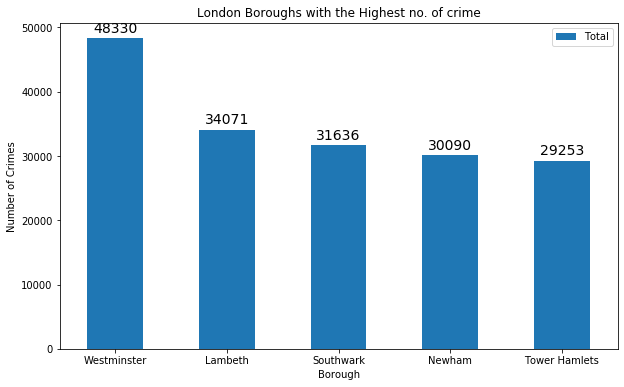

In [41]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

In [44]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,2,2,10,6,4,129,25,178
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,879,1054,743,189,121,3803,3194,9983
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,1233,1316,461,253,165,3516,3714,10658
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,1359,1148,320,217,106,4769,3155,11074
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,1419,1418,466,249,283,4894,4026,12755


In [45]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,178,1.12,7000


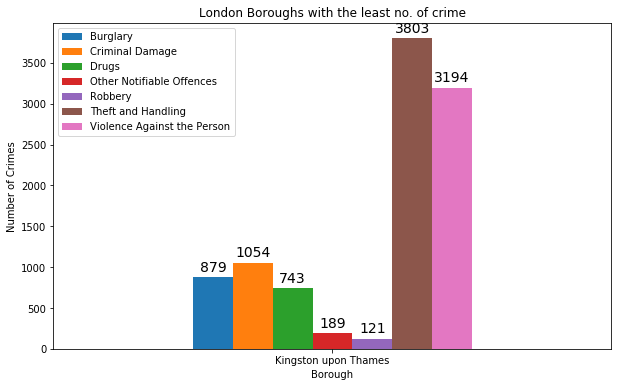

In [46]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

Conclusion: Kingston Upon Thames is the safest

**Simple Description:** Kingston upon Thames, is a town, former manor, ecclesiastical parish and borough now within Greater London, England, formerly within the county of Surrey. It is situated on the River Thames, about 33 feet above sea level and 10 miles southwest of Charing Cross.

Source: Wikipedia